In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import json
from PIL import Image, ImageDraw
import shutil

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 11.3 MB/s eta 0:00:00


In [3]:
os.makedirs('datasets', exist_ok=True)
%cd datasets

/content/datasets


In [4]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1tgZfPPyTfSp23oBfsBqXvvA_Ktl2KmVl',
    'urban_dataset.zip'
)


In [5]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('urban_dataset.zip')
%cd ..

Extracted all
/content


In [6]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [7]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [8]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(18, 16))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(3, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


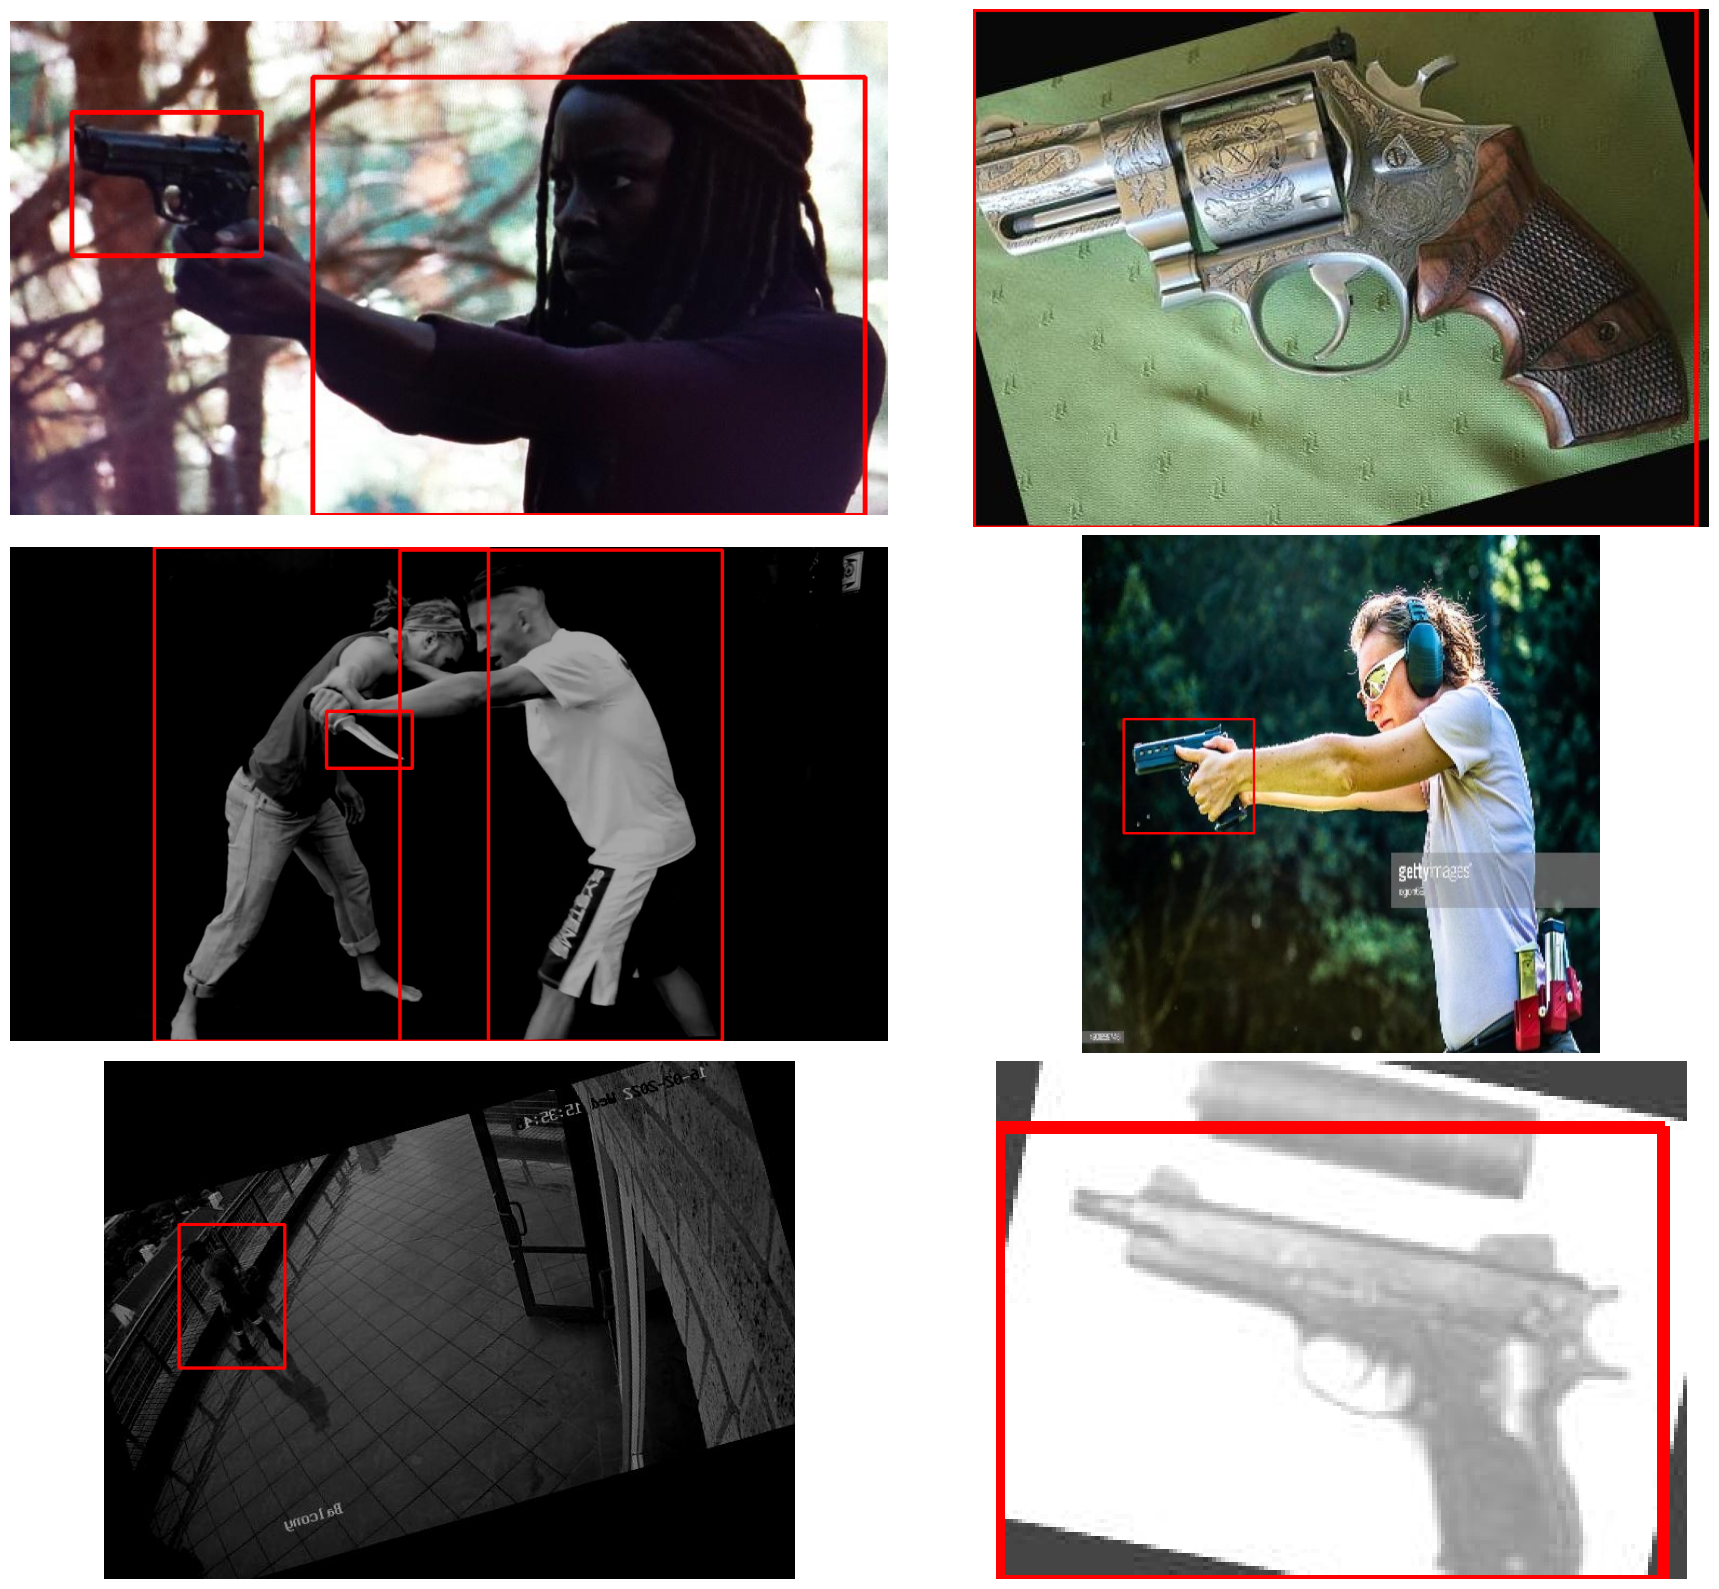

In [9]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=6,
)

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data='/content/datasets/data.yaml' epochs=64 augment=True optimizer='AdamW' lr0=.0015 augment=True batch=64 patience = 8 dropout=.1  name=yolov8s_custom

100% 21.5M/21.5M [00:00<00:00, 325MB/s]
Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/data.yaml, epochs=64, patience=8, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_

In [ ]:
!yolo task=detect model=runs/detect/yolov8s_custom/weights/best.pt data='/content/datasets/data.yaml' epochs=32 augment=True optimizer='AdamW' lr0=.0005 augment=True batch=64 patience = 8 dropout=.05  name=yolov8s_custom

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8s_custom/weights/best.pt name=yolov8s_eval data='/content/datasets/data.yaml'

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8s_custom/weights/best.pt \
source=datasets/test/images \
name=yolov8s_custom_finish \
#hide_labels=False

In [ ]:
img=Image.open("/content/runs/detect/yolov8s_custom2/results.png")
plt.figure(figsize=(10, 10))
plt.imshow(img, interpolation='bicubic')
plt.show()

**medium**

In [10]:
!yolo task=detect mode=train model=yolov8m.pt data='/content/datasets/data.yaml' epochs=64 augment=True optimizer='AdamW' lr0=.0005 augment=True batch=64 patience = 8 dropout=.1  name=yolov8m_custom

100% 49.7M/49.7M [00:00<00:00, 464MB/s]
Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/data.yaml, epochs=64, patience=8, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_custom, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_

In [12]:
!yolo task=detect mode=train model=runs/detect/yolov8m_custom/weights/best.pt data='/content/datasets/data.yaml' epochs=16 augment=True optimizer='AdamW' lr0=.00025 momentum=0.99 augment=True batch=64 patience = 4 name=yolov8m_custom

WARNING ⚠️ 'mode' is missing. Valid modes are ('train', 'val', 'predict', 'export', 'track', 'benchmark'). Using default 'mode=train'.
Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/yolov8m_custom/weights/best.pt, data=/content/datasets/data.yaml, epochs=16, patience=4, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_custom2, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

In [21]:
!yolo task=detect mode=train model=runs/detect/yolov8m_custom2/weights/best.pt data='/content/datasets/data.yaml' epochs=32 augment=True optimizer='AdamW' lr0=.0005 momentum=.99 batch=96 patience = 8 dropout=.01 name=yolov8m_custom

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/yolov8m_custom2/weights/best.pt, data=/content/datasets/data.yaml, epochs=32, patience=8, batch=96, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_custom8, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.01, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks

In [22]:
!yolo task=detect mode=val model=runs/detect/yolov8m_custom8/weights/best.pt name=yolov8m_eval data='/content/datasets/data.yaml'

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 487 images, 0 backgrounds, 0 corrupt: 100% 487/487 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 36, len(boxes) = 930. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 31/31 [00:05<00:00,  5.21it/s]
                   all        487        930      0.862      0.719      0.803       0.57
                 knife        487         81      0.897      0.914      0.966      0.664
          long_weapons        487         94      0.816      0.511      0.591      0.404
       man_with_weapon        48

In [23]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8m_custom2/weights/best.pt \
source=datasets/test/images \
name=yolov8m_custom_finish \
#hide_labels=False

Ultralytics YOLOv8.0.202 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs

image 1/492 /content/datasets/test/images/1-113-_jpg.rf.8018be0ad492ea109442aea621601732.jpg: 640x640 1 short_weapons, 10.9ms
image 2/492 /content/datasets/test/images/1-124-_jpg.rf.ca069de125e41c71de86d39556854d8f.jpg: 640x640 (no detections), 9.2ms
image 3/492 /content/datasets/test/images/1-127-_jpg.rf.68352c089a1e44a14997dd4a0eebdbf7.jpg: 640x640 1 short_weapons, 9.2ms
image 4/492 /content/datasets/test/images/1-140-_jpg.rf.72a0eaf5f644e439fa04e1b341db7085.jpg: 640x640 1 short_weapons, 8.8ms
image 5/492 /content/datasets/test/images/1-150-_jpg.rf.7c1d17c882e1a689226a17b72b97a7f6.jpg: 640x640 1 short_weapons, 9.1ms
image 6/492 /content/datasets/test/images/1-155-_jpg.rf.1dcaffa227aa19aedcd009d4803f9f57.jpg: 640x640 1 short_weapons, 8.7ms
image 7/492 /content/datasets/test/images/1-157-_jpg.rf.0ef5944dd2

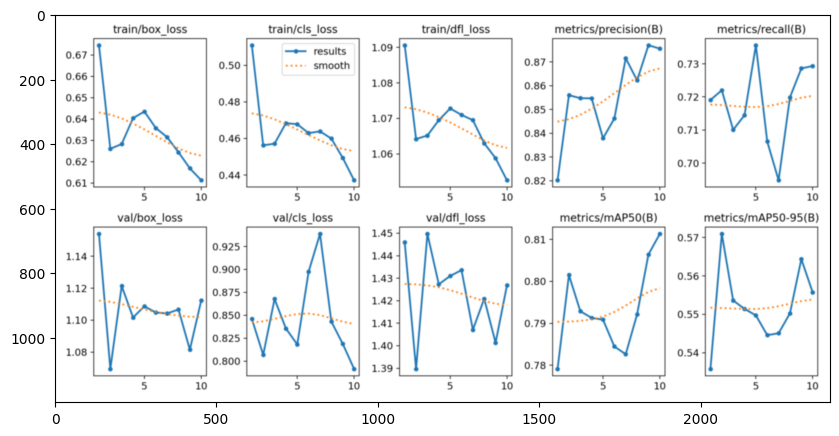

In [26]:
img=Image.open("/content/runs/detect/yolov8m_custom8/results.png")
plt.figure(figsize=(10, 10))
plt.imshow(img, interpolation='bicubic')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
source_path = '/content/runs/detect/yolov8s_custom2/weights/best.pt'  # Replace with the actual path to your x.txt file.
destination_path = '/content/drive/MyDrive'  # Replace with the desired destination in Google Drive.

!cp $source_path $destination_path
